### **1. Import Libraries**
**Description**: Import the necessary libraries for data manipulation, graph construction, and GNN modeling.

In [41]:
# Basic libraries
import pickle
import pandas as pd
import numpy as np

# Graph processing
import networkx as nx

# PyTorch and PyTorch Geometric
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader

# Utilities
import random
from sklearn.feature_extraction.text import TfidfVectorizer
import torch.nn as nn
import torch.nn.functional as F

### **2. Load and Preprocess the Dataset**
**Description**: Load the dataset, parse paper metadata, and construct the citation relationships.

In [42]:
def parse_papers(file_path):
    # Read the file and split by double newlines (delimiter between papers)
    with open(file_path, 'r') as file:
        paper_blocks = file.read().strip().split("\n\n")
    
    # Initialize list to store paper data
    papers = []
    
    # Process each paper block
    for block in paper_blocks:
        current_paper = {
            "title": None,
            "authors": None,
            "year": None,
            "venue": None,
            "index": None,
            "citations": [],
            "abstract": None,
        }
        # Process lines within the block
        for line in block.split("\n"):
            line = line.strip()
            if line.startswith('#*'):  # Title
                current_paper["title"] = line[2:]
            elif line.startswith('#@'):  # Authors
                current_paper["authors"] = line[2:]
            elif line.startswith('#t'):  # Year
                current_paper["year"] = line[2:]
            elif line.startswith('#c'):  # Venue
                current_paper["venue"] = line[2:]
            elif line.startswith('#index'):  # Index
                current_paper["index"] = line[6:]
            elif line.startswith('#%'):  # Citations
                current_paper["citations"].append(line[2:])
            elif line.startswith('#!'):  # Abstract
                current_paper["abstract"] = line[2:]
            
        papers.append(current_paper)
    
    # Convert to DataFrame
    df = pd.DataFrame(papers)
    df["citations"] = df["citations"].apply(lambda x: ";".join(x) if x else None)
    return df

In [43]:
# Load dataset and preprocess
file_path = "Data/papers.txt"
df = parse_papers(file_path)

# Load category mappings and merge
with open('Data/pid_cat_dict.pkl', 'rb') as file:
    picke_df = pickle.load(file)
picke_df = pd.DataFrame(picke_df.items(), columns=['index', 'categories'])
df = df.merge(picke_df, on='index', how='left')

# Fill missing abstracts and convert citations to lists
df['abstract'] = df['abstract'].fillna("")
df['citations'] = df['citations'].apply(lambda x: x.split(';') if pd.notnull(x) else [])

### encoding

In [44]:
categories_flat = [category for sublist in df['categories'] for category in sublist]
unique_categories = sorted(set(categories_flat))

for category in unique_categories:
    df[f'category_{category}'] = df['categories'].apply(lambda x: 1 if category in x else 0)

In [45]:
# export the dataframe in a pickle file
df.to_pickle('Data/preprocessed_df.pkl')

# Load the dataframe
df = pd.read_pickle('Data/preprocessed_df.pkl')

In [46]:
df['categories'] = df['categories'].apply(lambda x: len(x) if x else None)

In [47]:
df

,title,authors,year,venue,index,citations,abstract,categories,category_0,category_1,...,category_25,category_26,category_27,category_28,category_29,category_30,category_31,category_32,category_33,category_34
0,Automated Deduction in Geometry: 5th Internati...,"Hoon Hong,Dongming Wang",2006,,0,[],,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A+ Certification Core Hardware (Text & Lab Man...,Charles J. Brooks,2003,,1,[],,2,0,0,...,1,0,0,0,0,0,0,0,0,0
2,Performance engineering in industry: current p...,"Ahmed E. Hassan,Parminder Flora",2007,Proceedings of the 6th international workshop ...,2,[],This panel session discusses performance engin...,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Dude, You Can Do It! How to Build a Sweeet PC","Darrel Creacy,Carlito Vicencio",2005,,3,[],Whether you're frustrated with current PC offe...,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,What Every Programmer Needs to Know about Secu...,"Neil Daswani,Anita Kesavan",2006,,4,[],,2,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629809,Mining A,,2008,Proceedings of the VLDB Endowment,629809,[],,1,0,0,...,0,0,0,0,0,0,0,0,0,1
629810,Review article,,2008,Communications of the ACM,629810,[],,1,0,0,...,0,0,0,0,0,0,0,0,1,0
629811,Multimodal system evaluation using modality ef...,"Manolis Perakakis,Alexandros Potamianos",2008,Proceedings of the 10th international conferen...,629811,"[294663, 302639, 572828]","In this paper, we propose two new objective me...",2,0,1,...,0,0,0,0,0,0,0,0,0,0
629812,Computer System Architecture,V. K. Jain,2007,,629812,[],,2,0,1,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# Drop abstract and title
data = df.drop(columns=["title", "abstract"])

# Convert venue to binary: 1 if venue exists, 0 if not
data['venue_exists'] = data['venue'].apply(lambda x: 1 if x else 0)
data

,authors,year,venue,index,citations,categories,category_0,category_1,category_2,category_3,...,category_26,category_27,category_28,category_29,category_30,category_31,category_32,category_33,category_34,venue_exists
0,"Hoon Hong,Dongming Wang",2006,,0,[],2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Charles J. Brooks,2003,,1,[],2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Ahmed E. Hassan,Parminder Flora",2007,Proceedings of the 6th international workshop ...,2,[],2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,"Darrel Creacy,Carlito Vicencio",2005,,3,[],1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Neil Daswani,Anita Kesavan",2006,,4,[],2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629809,,2008,Proceedings of the VLDB Endowment,629809,[],1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
629810,,2008,Communications of the ACM,629810,[],1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
629811,"Manolis Perakakis,Alexandros Potamianos",2008,Proceedings of the 10th international conferen...,629811,"[294663, 302639, 572828]",2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
629812,V. K. Jain,2007,,629812,[],2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### **3. Construct the Citation Graph**
**Description**: Create a directed graph where nodes are papers and edges represent citation relationships.

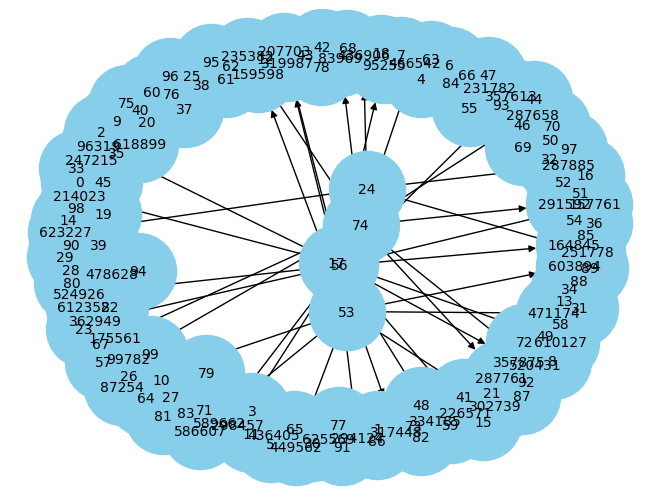

In [69]:
import networkx as nx

# Create an empty directed graph
data_part = data[:100]
G = nx.DiGraph()
# Add nodes and edges to the graph
for idx, row in data_part.iterrows():
    paper_id = row['index']
    G.add_node(paper_id)  # Add the node (paper)
    for cited_paper in row['citations']:  # Add an edge for each citation
        G.add_edge(paper_id, cited_paper)

# Visualizing the citation graph
import matplotlib.pyplot as plt
nx.draw(G, with_labels=True, node_size=3000, node_color='skyblue', font_size=10)
plt.show()

### **4. Generate Node Features**
**Description**: Compute node features using TF-IDF embeddings for abstracts and other metadata.

In [ ]:
# # Generate TF-IDF embeddings for abstracts
# vectorizer = TfidfVectorizer(max_features=5000)
# tfidf_matrix = vectorizer.fit_transform(df['abstract']).toarray()

# # Map node indices to features
# node_features = {row.index: tfidf_matrix[i] for i, row in enumerate(df.itertuples())}

# # Add node features to the graph
# nx.set_node_attributes(G, node_features, 'feature')

### **5. Convert to PyTorch Geometric Format**
**Description**: Convert the graph to a PyTorch Geometric `Data` object with nodes and edges for GNN training.

In [66]:
[G.nodes for node in G.nodes]

[NodeView(('0', '1', '2', '3', '4', '5', '436405', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '357875', '214023', '317448', '319987', '334185', '95255', '294124', '96319', '610127', '18', '19', '20', '21', '22', '23', '24', '251778', '436906', '623227', '287885', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '247215', '618899', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '159598', '603894', '586607', '471174', '87254', '302739', '449562', '54', '55', '231782', '56', '207703', '362949', '357613', '226571', '298457', '524926', '589662', '164845', '157761', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '175561', '466542', '287761', '99782', '287658', '520431', '235382', '291592', '83969', '75', '76', '77', '78', '79', '625569', '612358', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', 

In [67]:
# Create a mapping of node IDs to integer indices
node_id_mapping = {node: idx for idx, node in enumerate(G.nodes)}

node_features = np.array([G.nodes[node]['feature'] for node in G.nodes])
x = torch.tensor(node_features, dtype=torch.float)

# Convert edges to a list of integer pairs
edge_list = [(node_id_mapping[u], node_id_mapping[v]) for u, v in G.edges]

# Convert edge list to tensor and transpose it
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

# Create PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index)

KeyError: 'feature'

In [ ]:
data

Data(x=[629814, 5000], edge_index=[2, 632751])

### **6. Define the GNN Model**
**Description**: Build a GCN-based model to learn graph representations and predict citation relationships.

In [ ]:
class GCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the model
input_dim = x.shape[1]
hidden_dim = 128
output_dim = 2  # Binary classification: citation or not
model = GCNModel(input_dim, hidden_dim, output_dim)

### **7. Train-Test Split**
**Description**: Create training and test datasets for node classification tasks.

In [ ]:
# Split edges into train/test sets
edges = list(G.edges)
random.shuffle(edges)
split_idx = int(0.8 * len(edges))
train_edges = edges[:split_idx]
test_edges = edges[split_idx:]

# Generate labels (1 for true edges, 0 for random negative samples)
train_labels = torch.tensor([1] * len(train_edges), dtype=torch.float)
test_labels = torch.tensor([1] * len(test_edges), dtype=torch.float)

### **8. Define Loss Function and Optimizer**
**Description**: Set up the loss function and optimizer for training the GNN.

In [ ]:
# Define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

### **9. Train the Model**
**Description**: Train the GNN model on the training data and evaluate its performance on the test set.

In [ ]:
# Ensure 'index' column is string
df['index'] = df['index'].astype(str)

# Ensure 'citations' is a list of strings
df['citations'] = df['citations'].apply(lambda x: [str(c) for c in x])

# Construct edge list efficiently
valid_indices = set(df['index'])
edge_list = [
    (row['index'], target)
    for _, row in df.iterrows()
    for target in row['citations']
    if target in valid_indices
]

# Normalize edge format
edge_list = [(str(u), str(v)) for u, v in edge_list]
train_edges = [(str(u), str(v)) for u, v in train_edges]  # Assumes `train_edges` is defined

# Create mapping
edge_index_mapping = {edge: idx for idx, edge in enumerate(edge_list)}

# Ensure train_edges exist in edge_index_mapping and convert to tensor
train_edge_indices = torch.tensor(
    [edge_index_mapping[edge] for edge in train_edges if edge in edge_index_mapping],
    dtype=torch.long
)


In [ ]:
print(f"Example edge_list item: {edge_list[0]}")
print(f"Example train_edges item: {train_edges[0]}")


Example edge_list item: ('5', '436405')
Example train_edges item: ('293213', '171664')


In [ ]:
missing_edges = [edge for edge in train_edges if edge not in edge_index_mapping]
print(f"Missing edges: {missing_edges}")

Missing edges: []


In [ ]:
# Normalize edge format if needed
edge_list = [(str(u), str(v)) for u, v in edge_list]
train_edges = [(str(u), str(v)) for u, v in train_edges]

# Create mapping
edge_index_mapping = {edge: idx for idx, edge in enumerate(edge_list)}

# Ensure train_edges exist in edge_index_mapping
train_edge_indices = torch.tensor(
    [edge_index_mapping[edge] for edge in train_edges if edge in edge_index_mapping],
    dtype=torch.long
)

In [ ]:

# Extract features for the training edges only
train_edge_features = data.edge_index[:, train_edge_indices]

# Updated data object for training edges
train_data = Data(x=data.x, edge_index=train_edge_features)

# Updated training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Get model predictions for training data
    out = model(train_data)
    
    # Use only training labels for the loss
    loss = loss_fn(out, train_labels)
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")


ValueError: Expected input batch_size (629814) to match target batch_size (506200).

### **10. Evaluate the Model**
**Description**: Evaluate the model using accuracy, precision, and recall.

In [ ]:
# Evaluate
model.eval()
with torch.no_grad():
    predictions = model(data).argmax(dim=1)
    accuracy = (predictions == test_labels).sum().item() / len(test_labels)
    print(f"Test Accuracy: {accuracy}")

### **11. Visualize the Graph**
**Description**: Visualize the citation network and node embeddings.

In [ ]:
import matplotlib.pyplot as plt

# Visualize graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_size=50, alpha=0.7)
plt.show()